# Merging of finantial states with ratings

In [ ]:
#!/usr/bin/env python
# coding: utf-8

import pickle
from collections import defaultdict
import sys
from itertools import groupby
import numpy as np
import pandas as pd
from collections import Counter
import gc
from io import StringIO
import datetime

def clear_issuer_name(name):
    name = name.replace(' CORPORATION', '')
    name = name.replace(' CORP', '')
    name = name.replace(' GROUP', '')
    name = name.replace(' INC', '')
    name = name.replace(' CO', '')
    name = name.replace(' S.A.', '')
    name = name.replace(' SA', '')
    name = name.replace(' LP', '')
    name = name.replace(' LTD', '')
    name = name.replace(' LLC', '')
    name = name.replace(' /DE/', '')
    name = name.replace(' /CAN/', '')
    name = name.replace(' LP', '')
    name = name.replace(' /MD/', '')
    name = name.replace(', LP', '')
    name = name.replace(', LP', '')
    name = name.replace(' PLC', '')
    name = name.replace(' LP', '')

    if name.endswith('.'):
        name = name.replace('.', '')

    if name.endswith(','):
        name = name.replace(',', '')

    return name

def get_feats(d, feats):
    return {feat: getattr(d, feat) for feat in feats}

def load_dataset(fin_data_path, rating_path='./datasets/ratings_for_upload.csv'):
    print(fin_data_path, rating_path)

    rating_feats = []
    print('Loading rating data.')
    ratings = pd.read_csv(rating_path)

    rating_feats.append('rating_agency_name')
    rating_feats.append('issuer_name')
    rating_feats.append('rating_type')
    rating_feats.append('rating')
    rating_feats.append('rating_action_date')
    rating_feats.append('file_creating_date')
    rating_feats.append('maturity_date')
    rating_feats.append('sec_category')
    rating_feats.append('issuer_clean')

    print('Loading financial num data.')
    with open(f'./datasets/{fin_data_path}/num.txt') as op:
        df_num = pd.read_csv(StringIO(op.read()),sep='\t')

    print('Loading financial sub data.')
    with open(f'./datasets/{fin_data_path}/sub.txt') as op:
        df_sub = pd.read_csv(StringIO(op.read()),sep='\t')

    adsh_to_name = dict(zip(df_sub.adsh, df_sub.name))

    df_num['issuer_clean'] = df_num['adsh'].apply(adsh_to_name.get).apply(clear_issuer_name)

    del df_sub

    tbt = set(["Standard & Poor's Ratings Services", "Moody's Investors Service", "Fitch Ratings"])
    ratings['issuer_clean'] = ratings['issuer_name'].astype(str).apply(str.upper).apply(clear_issuer_name)
    _ratings = ratings[ratings['issuer_clean'].isin(set(df_num['issuer_clean']))].copy()
    _ratings = _ratings[_ratings['rating_agency_name'].isin(tbt)].copy()
    del ratings
    ratings_per_company = {comp:[] for comp in _ratings['issuer_clean']}

    for row in _ratings.itertuples(index=False):
        ratings_per_company[getattr(row, 'issuer_clean')].append(get_feats(row, rating_feats))

    _sec_num = df_num[df_num['issuer_clean'].isin(set(_ratings['issuer_clean']))].copy()

    del _ratings
    del df_num

    fin_statements = {k: defaultdict(dict) for k in set(_sec_num['issuer_clean'])}

    print('Loading fin statements.')

    for row in _sec_num.itertuples(index=False):
        tag = getattr(row, 'tag')
        qtrs = getattr(row, 'qtrs')
        dt = datetime.datetime.strptime(str(getattr(row, 'ddate')), '%Y%m%d')
        clear_issuer = clear_issuer_name(adsh_to_name[getattr(row, 'adsh')])

        fin_statements[clear_issuer][f'{dt.strftime("%Y_%m")}_{qtrs}Q'][tag] = getattr(row, 'value')

    del _sec_num

    fin_statements_per_year = defaultdict(dict)

    for k in fin_statements:
        for year, group in groupby(sorted(fin_statements[k]), lambda s: s[:4]):
            fin_statements_per_year[k][year] = {}

            for statement in group:
                fin_statements_per_year[k][year].update(fin_statements[k][statement])

    dataset = []

    print('Creating dataset rows.')

    for cmp, ratings in ratings_per_company.items():

        for r in ratings:
            r_year = r['rating_action_date'][0:4]

            if r_year not in fin_statements_per_year[cmp]:
                continue

            row = {}
            row['company'] = cmp
            row['rating'] = r['rating']
            row['rating_type'] = r['rating_type']
            row['rating_agency'] = r['rating_agency_name']
            row['year'] = r_year

            row.update(fin_statements_per_year[cmp][r_year])

            dataset.append(row)

    del ratings_per_company
    del fin_statements
    del fin_statements_per_year

    return dataset

run = False

if run:
    dataset = []
    
    #for year, quarter in ((i,j) for i in ['2015'] for j in ['4']):
    for year, quarter in ((i,j) for i in range(2013,2016) for j in range(1,5)):
        print(len(dataset))
        print(f'{sys.getsizeof(dataset)*0.000001} Mbs\n')
        dataset.extend(load_dataset(f'{year}q{quarter}'))
        print(len(dataset))
        print(f'{sys.getsizeof(dataset)*0.000001} Mbs\n')
    
        gc.collect()
        with open('dataset.pk', 'wb') as handle:
            pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('dataset.pk', 'rb') as handle:
    dataset = pickle.load(handle)

datasets_hash = [hash(frozenset(row.items())) for row in dataset]
_, idxs = np.unique(datasets_hash, return_index=True)

np_dataset = np.array(dataset)
unique_dataset = np_dataset[idxs]

columns = []

for row in unique_dataset:
    columns.extend(row.keys())

count_cols = Counter(columns)
most_common = count_cols.most_common(100)
common_cols = [x[0] for x in most_common]

_data = []

for row in unique_dataset:
    _data.append({k:row.get(k, np.nan) for k in common_cols})

df = pd.DataFrame.from_records(_data)
df.to_csv('./datasets/dataset_ready.csv')


# Example of a Decision Tree



In [ ]:
!pip install -U scikit-learn
!pip install -U xgboost
!pip install -U pandas

In [ ]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier

def test_clf(clf, X_train, X_test, y_train, y_test, binary=True):
    score = {}
  
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)

    score['test_acc'] = accuracy_score(y_test, y_test_pred)
    score['train_acc'] = accuracy_score(y_train, y_train_pred)

    if binary:
      score['test_f1'] = f1_score(y_test, y_test_pred, average='binary')
      score['test_recall'] = recall_score(y_test, y_test_pred, average='binary')

    else:
      score['test_f1'] = f1_score(y_test, y_test_pred, average='weighted')
      score['test_recall'] = recall_score(y_test, y_test_pred, average='weighted')

    return score


wine_X, wine_y = load_wine(return_X_y=True)

kwa = {}

kwa['random_state'] = 42
kwa['test_size'] = 0.2

X_train, X_test, y_train, y_test = train_test_split(wine_X, wine_y, **kwa)
tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)
test_clf(tree, X_train, X_test, y_train, y_test, binary=False)

{'test_acc': 0.9444444444444444,
 'test_f1': 0.9439974457215836,
 'test_recall': 0.9444444444444444,
 'train_acc': 1.0}

In [ ]:
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import graphviz

plt.figure(figsize=(10,10))

kwa = {}

kwa['decision_tree'] = tree
kwa['out_file'] = None
kwa['feature_names'] = load_wine()['feature_names']
kwa['class_names'] = load_wine()['target_names']
kwa['filled'] = True
kwa['label'] = 'root'
kwa['rounded'] = False
kwa['leaves_parallel'] = False
kwa['impurity'] = False
kwa['special_characters'] = True
kwa['proportion'] = False
kwa['precision'] = 2
kwa['rotate'] = False
kwa['fontname'] = 'times'

dot_data = export_graphviz(**kwa)

graph = graphviz.Source(dot_data)

graph.render(format='pdf', view=True)

'Source.gv.pdf'

<Figure size 720x720 with 0 Axes>

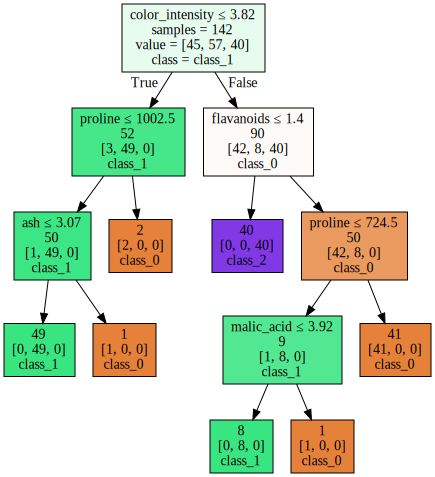

In [ ]:
graph

# Modelling of the problem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
from collections import defaultdict
import sys
from itertools import groupby
import numpy as np
import pandas as pd
from collections import Counter
import gc
from io import StringIO
import datetime

dataset = pd.read_csv('/content/drive/MyDrive/tcc/dataset_ready.csv')

In [ ]:
set(dataset['rating'])

{'(P)A2',
 '(P)A3',
 '(P)Aa2',
 '(P)Aa3',
 '(P)B1',
 '(P)B2',
 '(P)B3',
 '(P)Ba1',
 '(P)Ba2',
 '(P)Ba3',
 '(P)Baa1',
 '(P)Baa2',
 '(P)Baa3',
 '(P)C',
 '(P)Ca',
 '(P)Caa1',
 '(P)Caa2',
 '(P)Caa3',
 'A',
 'A (sf)',
 'A+',
 'A+prelim',
 'A-',
 'A- (sf)',
 'A-1',
 'A-1(HIGH)',
 'A-1(LOW)',
 'A-1(MID)',
 'A-1+',
 'A-1+prelim',
 'A-1prelim',
 'A-2',
 'A-3',
 'A-p',
 'A-prelim',
 'A1',
 'A2',
 'A2.ru',
 'A3',
 'A3.ru',
 'AA',
 'AA+',
 'AA+prelim',
 'AA-',
 'AA-prelim',
 'AA/A-1+',
 'AAA',
 'AAAm',
 'AAAprelim',
 'AAprelim',
 'Aa1',
 'Aa2',
 'Aa3',
 'Aaa',
 'Ap',
 'Aprelim',
 'Aprelim (sf)',
 'B',
 'B+',
 'B+prelim',
 'B-',
 'B-prelim',
 'B1',
 'B1-PD',
 'B2',
 'B2-PD',
 'B3',
 'B3-PD',
 'BB',
 'BB+',
 'BB+prelim',
 'BB-',
 'BB-prelim',
 'BBB',
 'BBB+',
 'BBB+(EXP)',
 'BBB+p',
 'BBB+prelim',
 'BBB-',
 'BBB- (sf)',
 'BBB-(EXP)',
 'BBB-prelim',
 'BBB-prelim (sf)',
 'BBBprelim',
 'BBprelim',
 'Ba1',
 'Ba1-PD',
 'Ba2',
 'Ba2-PD',
 'Ba3',
 'Ba3-PD',
 'Ba3.ru',
 'Baa1',
 'Baa2',
 'Baa3',
 'Baa3.ru',

In [ ]:
dataset['rating_type'].value_counts()

Instrument                                           28674
Local Currency Preliminary LT                        28468
Local Currency LT                                    12516
Long Term Rating                                      9901
Local Currency ST                                     5036
Organization                                          1774
Short Term Rating                                     1680
Foreign Currency LT                                   1557
Foreign Currency Preliminary LT                       1361
Program                                                695
S&P Published Underlying Rating                        589
Foreign Currency ST                                    422
Canada National Scale Commercial Paper                  85
Local Currency Preliminary ST                           49
Greater China Regional Scale LT                         26
Sale                                                    24
Foreign Currency Principal LT                           

In [ ]:
eu_quality_step = {
    'Aaa': "1", # Moody's Investors Service - Long-term
    'Aa1': "1",
    'Aa2': "1",
    'Aa3': "1",
    'A1': "2",
    'A2': "2",
    'A3': "2",
    'Baa1': "3",
    'Baa2': "3",
    'Baa3': "3",
    'Ba1': "4",
    'Ba2': "4",
    'Ba3': "4",
    'B1': "5",
    'B2': "5",
    'B3': "5",
    'Caa1': "6",
    'Caa2': "6",
    'Caa3': "6",
    'Ca': "6",
    'C': "6",
    'P-1': "1", # Moody's Investors Service - Short-term
    'P-2': "1",
    'P-3': "1",
    'Not Prime': "1",
    'AAA': "1", # Fitch Ratings - Long-term
    'AA+': "1",
    'AA': "1",
    'AA-': "1",
    'A+': "2",
    'A': "2",
    'A-': "2",
    'BBB+': "3",
    'BBB': "3",
    'BBB-': "3",
    'BB+': "4",
    'BB': "4",
    'BB-': "4",
    'B+': "5",
    'B': "5",
    'B-': "5",
    'CCC+': "6",
    'CCC': "6",
    'CCC-': "6",
    'CC': "6",
    'C': "6",
    'RD': "6", 
    'D': "6",
    'F1+': "1", # Fitch Ratings - Short-term
    'F1': "1",
    'F2': "2",
    'F3': "3",
    'B': "4",
    'C': "6",
    'D': "6",
    'AAA': "1", # Standard & Poor's Ratings Services - Long-term
    'AA+': "1",
    'AA': "1",
    'AA-': "1",
    'A+/A1': "2",
    'A+': "2",
    'A': "2",
    'A-': "2",
    'BBB+': "3",
    'BBB': "3",
    'BBB-': "3",
    'BB+': "4",
    'BB': "4",
    'BB-': "4",
    'B+': "5",
    'B': "5",
    'B-': "5",
    'CCC+': "6",
    'CCC': "6",
    'CCC-': "6",
    'CC': "6",
    'C': "6",
    'RD': "6", 
    'SD': "6",
    'D': "6",
    'A-1+': "1", # Standard & Poor's Ratings Services - Short-term
    'A-1': "2",
    'A-2': "3",
    'A-3': "3",
    'B': "4",
    'C': "6",
    'D': "6"
}

In [ ]:
i_s_mapping = {
    '1': 1, # Standard & Poor's Ratings Services - Short-term
    '2': 1,
    '3': 1,
    '4': 0,
    '5': 0,
    '6': 0
}

In [ ]:
rep = ['-PD', 'm','za','\(P\)', 'preli', 'PD', '\(EXP\)', ' \(sf\)', '.ru']
rep.extend(['\(HIGH\)', '\(LOW\)', '\(MID\)', '\(High\)', 'p'])
rep.extend(['cn', 'p', 'z'])
rating_map = dataset["rating"]

for sub in rep:
  rating_map = rating_map.str.replace(sub, '')

dataset['rating_step'] = rating_map.map(eu_quality_step)
dataset['investment_or_speculative'] = dataset['rating_step'].map(i_s_mapping)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [ ]:
dataset['rating_step'].value_counts()

3    27738
4    18288
2    11733
5    10664
6     5726
1     3668
Name: rating_step, dtype: int64

In [ ]:
dataset.head()

,Unnamed: 0,company,rating,rating_type,rating_agency,year,CashAndCashEquivalentsAtCarryingValue,IncomeTaxExpenseBenefit,Assets,LiabilitiesAndStockholdersEquity,AccumulatedOtherComprehensiveIncomeLossNetOfTax,CashAndCashEquivalentsPeriodIncreaseDecrease,NetIncomeLoss,StockholdersEquity,ComprehensiveIncomeNetOfTax,RetainedEarningsAccumulatedDeficit,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesOutstandingBasic,EarningsPerShareBasic,EarningsPerShareDiluted,PropertyPlantAndEquipmentNet,InterestExpense,NetCashProvidedByUsedInInvestingActivities,OperatingIncomeLoss,CommonStockValue,NetCashProvidedByUsedInFinancingActivities,NetCashProvidedByUsedInOperatingActivities,Goodwill,ShareBasedCompensation,CommonStockSharesAuthorized,CommonStockParOrStatedValuePerShare,CommonStockSharesIssued,OtherComprehensiveIncomeLossNetOfTax,AssetsCurrent,LiabilitiesCurrent,DeferredIncomeTaxExpenseBenefit,PaymentsToAcquirePropertyPlantAndEquipment,Liabilities,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,OtherAssetsNoncurrent,...,NetIncomeLossAttributableToNoncontrollingInterest,IncomeLossFromEquityMethodInvestments,ProceedsFromPaymentsForOtherFinancingActivities,DeferredTaxLiabilitiesNoncurrent,ProceedsFromIssuanceOfLongTermDebt,LongTermDebtNoncurrent,IntangibleAssetsNetExcludingGoodwill,MinorityInterest,IncreaseDecreaseInAccountsReceivable,EntityCommonStockSharesOutstanding,AdditionalPaidInCapitalCommonStock,CommonStockDividendsPerShareDeclared,OtherComprehensiveIncomeLossForeignCurrencyTransactionAndTranslationAdjustmentNetOfTax,IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,LongTermDebt,IncomeTaxesPaidNet,PropertyPlantAndEquipmentGross,IncrementalCommonSharesAttributableToShareBasedPaymentArrangements,FiniteLivedIntangibleAssetsAccumulatedAmortization,PaymentsOfDividendsCommonStock,NetIncomeLossAvailableToCommonStockholdersBasic,InterestPaid,TreasuryStockShares,PreferredStockSharesAuthorized,UnrecognizedTaxBenefits,OtherAssetsCurrent,PaymentsToAcquireBusinessesNetOfCashAcquired,AllowanceForDoubtfulAccountsReceivableCurrent,ComprehensiveIncomeNetOfTaxAttributableToNoncontrollingInterest,OtherComprehensiveIncomeLossPensionAndOtherPostretirementBenefitPlansAdjustmentNetOfTax,AllocatedShareBasedCompensationExpense,NetCashProvidedByUsedInOperatingActivitiesContinuingOperations,PreferredStockValue,AdditionalPaidInCapital,ExcessTaxBenefitFromShareBasedCompensationFinancingActivities,OtherNoncashIncomeExpense,DeferredTaxAssetsNetCurrent,IncreaseDecreaseInOtherOperatingAssets,rating_step,investment_or_speculative
0,0,TEVA PHARMACEUTICAL INDUSTRIES,NRprelim,Foreign Currency Preliminary LT,Standard & Poor's Ratings Services,2015,1.068000e+09,192000000.0,5.037100e+10,5.037100e+10,-1.893000e+09,-1.158000e+09,985000000.0,2.303800e+10,436000000.0,1.483900e+10,859000000.0,850000000.0,1.16,1.15,6.427000e+09,NaN,-5.136000e+09,1.411000e+09,5.000000e+07,1.180000e+09,2.834000e+09,1.925700e+10,60000000.0,2.500000e+09,0.10,960000000.0,-547000000.0,1.329900e+10,1.447300e+10,NaN,354000000.0,2.728600e+10,2.308500e+10,3.173000e+09,...,-2000000.0,-3000000.0,-154000000.0,1.976000e+09,NaN,NaN,8.215000e+09,47000000.0,NaN,959693434.0,NaN,NaN,-685000000.0,NaN,NaN,NaN,NaN,NaN,NaN,578000000.0,NaN,NaN,110000000.0,NaN,NaN,NaN,3.261000e+09,NaN,NaN,4000000.0,NaN,NaN,NaN,1.432400e+10,NaN,NaN,1.352000e+09,NaN,NaN,NaN
1,1,KINDER MORGAN,BB-,Local Currency LT,Standard & Poor's Ratings Services,2011,4.090000e+08,361000000.0,3.071700e+10,3.071700e+10,-1.150000e+08,-9.100000e+07,594000000.0,8.568000e+09,NaN,-3.000000e+06,NaN,NaN,NaN,NaN,2.330000e+09,703000000.0,-2.392000e+09,1.423000e+09,NaN,-5.700000e+07,2.366000e+09,3.638000e+09,0.0,NaN,NaN,10120000.0,108000000.0,1.663000e+09,4.529000e+09,84000000.0,179000000.0,2.214900e+10,8.568000e+09,NaN,...,-66000000.0,22000000.0,-4000000.0,2.199000e+09,NaN,1.978000e+09,1.185000e+09,0.0,-8000000.0,NaN,NaN,1.05,-35000000.0,810000000.0,1.118300e+10,277000000.0

In [ ]:
dataset.reset_index()
dataset_clean = dataset.loc[dataset['investment_or_speculative'].notna()]
dataset_clean.dropna(axis='index', thresh=50, inplace=True)
dataset_clean.dropna(axis='columns', thresh=int(dataset_clean.shape[0]*.6), inplace=True)
# dataset_clean = dataset_clean.loc[dataset_clean['rating_type']]
drop_cols = ['company', 'rating', 'rating_type', 'Unnamed: 0', 'rating_agency', 'year', 'investment_or_speculative', 'OtherComprehensiveIncomeLossNetOfTax']
drop_cols.append('rating_step')

X = dataset_clean.drop(columns=drop_cols).copy()
y = dataset_clean['investment_or_speculative'].copy()

# X.dropna(axis='index', thresh=20, inplace=True)

In [ ]:
dataset_clean['rating_step'].value_counts()

3    16068
4    10636
2     6363
5     6141
6     2994
1     1819
Name: rating_step, dtype: int64

In [ ]:
X.fillna(0, inplace=True)

In [ ]:
mapper = {'CashAndCashEquivalentsAtCarryingValue': "Caixa ou Equivalentes",
 'IncomeTaxExpenseBenefit': "Despesa/Beneficio do IR",
 'Assets': "Ativos",
 'LiabilitiesAndStockholdersEquity': "Soma do Passivo e Patrimônio Líquido",
 'AccumulatedOtherComprehensiveIncomeLossNetOfTax': "Custos com transações",
 'CashAndCashEquivalentsPeriodIncreaseDecrease': "Aumento/Redução de caixa",
 'NetIncomeLoss': "Perda de renda líquida",
 'StockholdersEquity': "Patrimônio Líquido",
 'ComprehensiveIncomeNetOfTax': "Aumento/Redução Patrimônio Líquido",
 'RetainedEarningsAccumulatedDeficit': "Aumento/Redução do Lucro",
 'WeightedAverageNumberOfDilutedSharesOutstanding': "Núm. de Ações criadas",
 'WeightedAverageNumberOfSharesOutstandingBasic': "Núm. de Ações",
 'EarningsPerShareBasic':"Lucro/Prejuízo por Ação",
 'EarningsPerShareDiluted': "Lucro/Prejuízo por Ação Diluída",
 'PropertyPlantAndEquipmentNet': "Propriedade e Equipamentos",
 'InterestExpense': "Gastos com Juros",
 'NetCashProvidedByUsedInInvestingActivities': "Ganhos com investimentos",
 'OperatingIncomeLoss': "Perda de lucro por operação",
 'CommonStockValue': "Valor da ação comum",
 'NetCashProvidedByUsedInFinancingActivities': "Ganho/Perda com financiamento",
 'NetCashProvidedByUsedInOperatingActivities': "Ganho/Perda com operações",
 'Goodwill': "Patrimônio de marca",
 'ShareBasedCompensation': "Remuneração em Ações",
 'CommonStockSharesAuthorized': "Núm. Máx de ações de sócios",
 'CommonStockParOrStatedValuePerShare': "Valor declarado de ação comum",
 'CommonStockSharesIssued': "Valor declarado de sócios",
 'AssetsCurrent': "Ativos correntes",
 'LiabilitiesCurrent': "Passivo Circulante",
 'DeferredIncomeTaxExpenseBenefit': "Aumento/Redução de impostos",
 'PaymentsToAcquirePropertyPlantAndEquipment': "Investimentos em propriedades",
 'Liabilities': "Passivo",
 'StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest': "Patrimônio permanente",
 'OtherAssetsNoncurrent': "Ativos a longo prazo",
 'OtherLiabilitiesNoncurrent': "Passivos a longo prazo",
 'ProfitLoss': "Ganho/Lucro",
 'AccountsPayableCurrent': "Crédito a curto prazo",
 'AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment': "Depreciação/Amortização"}

X.rename(columns=mapper, inplace=True)

In [ ]:
for x in list(X.columns):
  print(x)

Caixa ou Equivalentes
Despesa/Beneficio do IR
Ativos
Soma do Passivo e Patrimônio Líquido
Custos com transações
Aumento/Redução de caixa
Perda de renda líquida
Patrimônio Líquido
Aumento/Redução Patrimônio Líquido
Aumento/Redução do Lucro
Núm. de Ações criadas
Núm. de Ações
Lucro/Prejuízo por Ação
Lucro/Prejuízo por Ação Diluída
Propriedade e Equipamentos
Gastos com Juros
Ganhos com investimentos
Perda de lucro por operação
Valor da ação comum
Ganho/Perda com financiamento
Ganho/Perda com operações
Patrimônio de marca
Remuneração em Ações
Núm. Máx de ações de sócios
Valor declarado de ação comum
Valor declarado de sócios
Ativos correntes
Passivo Circulante
Aumento/Redução de impostos
Investimentos em propriedades
Passivo
Patrimônio permanente
Ativos a longo prazo
Passivos a longo prazo
Ganho/Lucro
Crédito a curto prazo
Depreciação/Amortização


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

top_10 = [
'Núm. de Ações criadas',
'Patrimônio Líquido',
'Valor declarado de ação comum',
'Valor da ação comum',
'Passivos a longo prazo',
'Núm. de Ações',
'Lucro/Prejuízo por Ação Diluída',
'Aumento/Redução Patrimônio Líquido',
'Aumento/Redução do Lucro',
'Ativos']

kwa = {}

kwa['random_state'] = 43
kwa['test_size'] = 0.3

X_train, X_test, y_train, y_test = train_test_split(X[top_10], y, **kwa)
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=400,max_leaf_nodes=15)

tree.fit(X_train, y_train)
test_clf(tree, X_train, X_test, y_train, y_test, binary=False)

{'test_acc': 0.7965472855304006,
 'test_f1': 0.7958855303572552,
 'test_recall': 0.7965472855304006,
 'train_acc': 0.8083663269942234}

In [ ]:
dataset_clean['rating_step'].value_counts()

3    16068
4    10636
2     6363
5     6141
6     2994
1     1819
Name: rating_step, dtype: int64

In [ ]:
y_naive_test = np.repeat('3', len(y_test))
y_naive_train = np.repeat('3', len(y_train))

score = {}

score['test_f1'] = f1_score(y_test, y_naive_test, average='weighted')
score['test_acc'] = accuracy_score(y_test, y_naive_test)
score['test_recall'] = recall_score(y_test, y_naive_test, average='weighted')
score['train_f1'] = f1_score(y_train, y_naive_train, average='weighted')
score['train_acc'] = accuracy_score(y_train, y_naive_train)
score['train_recall'] = recall_score(y_train, y_naive_train, average='weighted')

print(score)

In [ ]:
24250/(24250+19771)

0.5508734467640445

In [ ]:
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import graphviz
 
plt.figure(figsize=(10,10))

kwa = {}

kwa['decision_tree'] = tree
kwa['out_file'] = None
kwa['feature_names'] = top_10
kwa['class_names'] = ['Especulativo', 'Investimento']
kwa['filled'] = True
kwa['label'] = 'root'
kwa['rounded'] = False
kwa['leaves_parallel'] = False
kwa['impurity'] = False
kwa['special_characters'] = True
kwa['proportion'] = False
kwa['precision'] = 2
kwa['rotate'] = False
kwa['fontname'] = 'times'

dot_data = export_graphviz(**kwa)

graph = graphviz.Source(dot_data)

graph.render(format='pdf', view=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


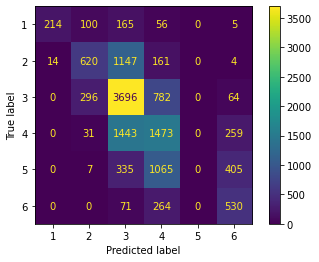

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(tree, X_test, y_test)

In [ ]:
from xgboost import XGBClassifier

kwa = {}

kwa['random_state'] = 43
kwa['test_size'] = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, **kwa)
xgb = XGBClassifier(max_depth=10)

xgb.fit(X_train, y_train)
print(test_clf(xgb, X_train, X_test, y_train, y_test, binary=False))

plot_confusion_matrix(xgb, X_test, y_test)

In [ ]:
kwa = {}

kwa['random_state'] = 43
kwa['test_size'] = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, **kwa)
tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)
test_clf(tree, X_train, X_test, y_train, y_test)

In [ ]:
import pickle

# Seleção de variáveis:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler

# Scoring:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix

# IO libs:
from pprint import pprint
import matplotlib.pyplot as plt

_SCORING = ['precision_micro']
_CV_K_FOLDS = 2
_N_OPTIMIZATION_ITERS = 20
r_seed = 42

class SolutionTester():
    def __init__(self, clfs, X, y, name):
        self.clfs = clfs
        self.name = name
        self.X = X
        self.y = y
        self.history = {}
        self.approaches = []
        self.SORT_BY = 'test_acc'
        self.scalers = {}


    def __test_clf(self, clf, X_test, X_train):
        y_test_pred = clf.predict(X_test)
        y_train_pred = clf.predict(X_train)

        score = {}

        score['test_acc'] = accuracy_score(self.y_test, y_test_pred)
        score['test_recall'] = recall_score(self.y_test, y_test_pred, average='macro')
        score['test_f1'] = f1_score(self.y_test, y_test_pred, average='macro')

        score['train_acc'] = accuracy_score(self.y_train, y_train_pred)
        score['train_recall'] = recall_score(self.y_train, y_train_pred, average='macro')
        score['train_f1'] = f1_score(self.y_train, y_train_pred, average='macro')

        return score

    def __gen_approaches(self):
        if len(self.approaches) > 0:
            return

        std_scaler = StandardScaler()
        rob_scaler = RobustScaler()
        pca = PCA(n_components=5)

        # Dividindo os dados entre treino e teste
        kwa = {}

        kwa['random_state'] = r_seed
        kwa['test_size'] = 0.30 # 30% para o teste e o resto para treino.

        X_train, X_test, _y_train, _y_test = train_test_split(X, y, **kwa)
        self.y_train, self.y_test = np.ravel(_y_train), np.ravel(_y_test)

        # O fit do scaler é feito apenas com os dados de treino.
        # Se o fit for feito com todos os dados teremos data leakage.
        X_train_scaled = std_scaler.fit_transform(X_train)
        X_test_scaled = std_scaler.transform(X_test)

        X_train_rob = rob_scaler.fit_transform(X_train)
        X_test_rob = rob_scaler.transform(X_test)

        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        self.scalers['Normalização Std'] = std_scaler
        self.scalers['Normalização Robusta'] = rob_scaler

        self.approaches.append([X_train, X_test, 'Originais'])
        self.approaches.append([X_train_scaled, X_test_scaled, 'Normalização Std'])
        self.approaches.append([X_train_rob, X_test_rob, 'Normalização Rob'])

    def save_progress(self):
        if self.name == 'fin_rating_bin':
            pickle.dump(self, open('/content/drive/MyDrive/tcc/models/binary/model_trained.pkl', 'wb'))
        else:
            pickle.dump(self, open('/content/drive/MyDrive/tcc/models/multiple/model_trained.pkl', 'wb'))

    @staticmethod
    def load_progress(name):
        if name == 'fin_rating_bin':
            return pickle.load(open('/content/drive/MyDrive/tcc/models/binary/model_trained.pkl', 'rb'))
        else:
            return pickle.load(open('/content/drive/MyDrive/tcc/models/multiple/model_trained.pkl', 'rb'))
    
    def run(self):
        self.__gen_approaches()

        for _X_train, _X_test, a_name in self.approaches:
            for clf, grid_params, clf_id in self.clfs:
                if (clf_id, a_name) in self.history:
                    continue

                hist, kwa = {}, {}

                kwa['estimator'] = clf()
                kwa['param_distributions'] = grid_params
                kwa['cv'] = _CV_K_FOLDS
                kwa['n_jobs'] = _CV_K_FOLDS
                kwa['n_iter'] = _N_OPTIMIZATION_ITERS

                print(clf, a_name)
                model_grid = RandomizedSearchCV(**kwa)
                model_grid.fit(_X_train, self.y_train)
                clf = model_grid.best_estimator_
                clf.fit(_X_train, self.y_train)


                hist['name'] = (clf_id, a_name)
                hist['score'] = self.__test_clf(clf, _X_test, _X_train)
                hist['clf'] = clf
                hist['params'] = model_grid.best_params_
                hist['X_train'] = _X_train
                hist['X_test'] = _X_test

                self.history[(clf_id, a_name)] = hist

                self.save_progress()

    def get_top_clfs(self, reverse=False):
        sort_key = lambda x: x['score'][self.SORT_BY]

        return sorted(self.history.values(), key=sort_key, reverse=reverse)

    def print_n_best_clfs(self, n):
        for clf in self.get_top_clfs()[-n:]:
            print(clf['name'])
            print(clf['score'])
            plot_confusion_matrix(clf['clf'], clf['X_test'], self.y_test)
            plt.show()

    def best_feat_imp_clf(self):
        for hist in self.get_top_clfs(reverse=True):
            if hasattr(hist['clf'], 'feature_importances_'):
                return hist['name']

    def get_imp_feats(self):
        f = []
        hist = self.history[self.best_feat_imp_clf()]

        for i, imp in enumerate(hist['clf'].feature_importances_):
            if imp != 0:
                f.append((imp, self.X.columns[i]))
        
        return sorted(f, key=lambda x: x[0])

    def print_importance_list(self):
        for imp in self.get_imp_feats():
            print(f'{imp[1]}: {imp[0]*100:.2f}%')

    def plot_imp_features(self):
        f = self.get_imp_feats()
        hist = self.history[self.best_feat_imp_clf()]

        plt.title(f'Importância das Características na modelagem {self.name}.')
        plt.barh(range(len(f)), [i[0] for i in f], color='b', align='center')
        plt.yticks(range(len(f)), [i[1] for i in f])
        plt.xlabel('Importância da característica')
        plt.suptitle(f'Acertividade {hist["score"]["test_acc"]*100}%')
        plt.show()


In [ ]:
import numpy as np

# Modelagem:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

clfs = []
grid_params_dt = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [3, 4, 5, 8, 10, 12, 15, 20, None],
    'min_samples_split': [5, 10, 15, 20, 30, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'min_samples_leaf': [3, 4, 6, 8, 10, 15, 0.01, 0.02, 0.03, 0.04, 0.05],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [5, 10, 15, 20, 25, None]
}
clfs.append((DecisionTreeClassifier, grid_params_dt, 'Árvore de decisão'))

grid_params_rf = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'bootstrap': [True, False],
    'warm_start': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 8, 10, 15, 20, 25, 30, None],
    'min_samples_leaf': [3, 4, 6, 8, 10, 15, 20, 25, 30, 0.01, 0.02, 0.03, 0.04, 0.05],
    'max_leaf_nodes': [5, 10, 15, 20, 25, 30, 40, None],
    'min_samples_split': [5, 10, 15, 20, 30, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'max_features': ['auto', 'sqrt', 'log2', None]
}
clfs.append((RandomForestClassifier, grid_params_rf, 'Floresta Randômica'))

grid_params_xgb = {
    'min_child_weight': [1, 2, 3, 4, 5, 6, 8, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300, 400, 500, 600]
}
clfs.append((XGBClassifier, grid_params_xgb, 'Gradient Boosting'))

In [ ]:
rating = SolutionTester(clfs, X, y, 'fin_rating_multiple')

rating.run()

In [ ]:
import pickle

pickle.dump(rating, open('test.pkl', 'wb'))

In [ ]:
rating_loaded = pickle.load(open('test.pkl', 'rb'))

In [ ]:
rating_bin = SolutionTester.load_progress('fin_rating_bin')
rating_mul = SolutionTester.load_progress('fin_rating_multiple')

('Gradient Boosting', 'Originais')
{'test_acc': 0.9108048762020141, 'test_recall': 0.929637234770705, 'test_f1': 0.920189701897019, 'train_acc': 0.9413578243655482, 'train_recall': 0.9529064620832104, 'train_f1': 0.9470103516025923}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


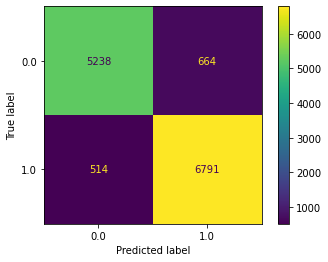

In [ ]:
rating_bin.print_n_best_clfs(1)

In [ ]:
rating_bin.print_n_best_clfs

<bound method SolutionTester.print_n_best_clfs of <__main__.SolutionTester object at 0x7f57fe2bc250>>

('Gradient Boosting', 'Normalização Rob')
{'test_acc': 0.7037177254486258, 'test_recall': 0.7037177254486258, 'test_f1': 0.7009940721056098, 'train_acc': 0.7846757967157786, 'train_recall': 0.7846757967157786, 'train_f1': 0.7832753800242807}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


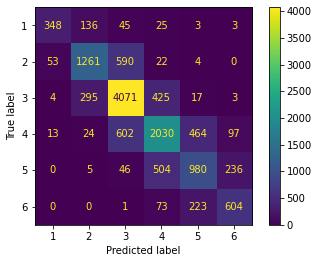

In [ ]:
rating_mul.print_n_best_clfs(1)

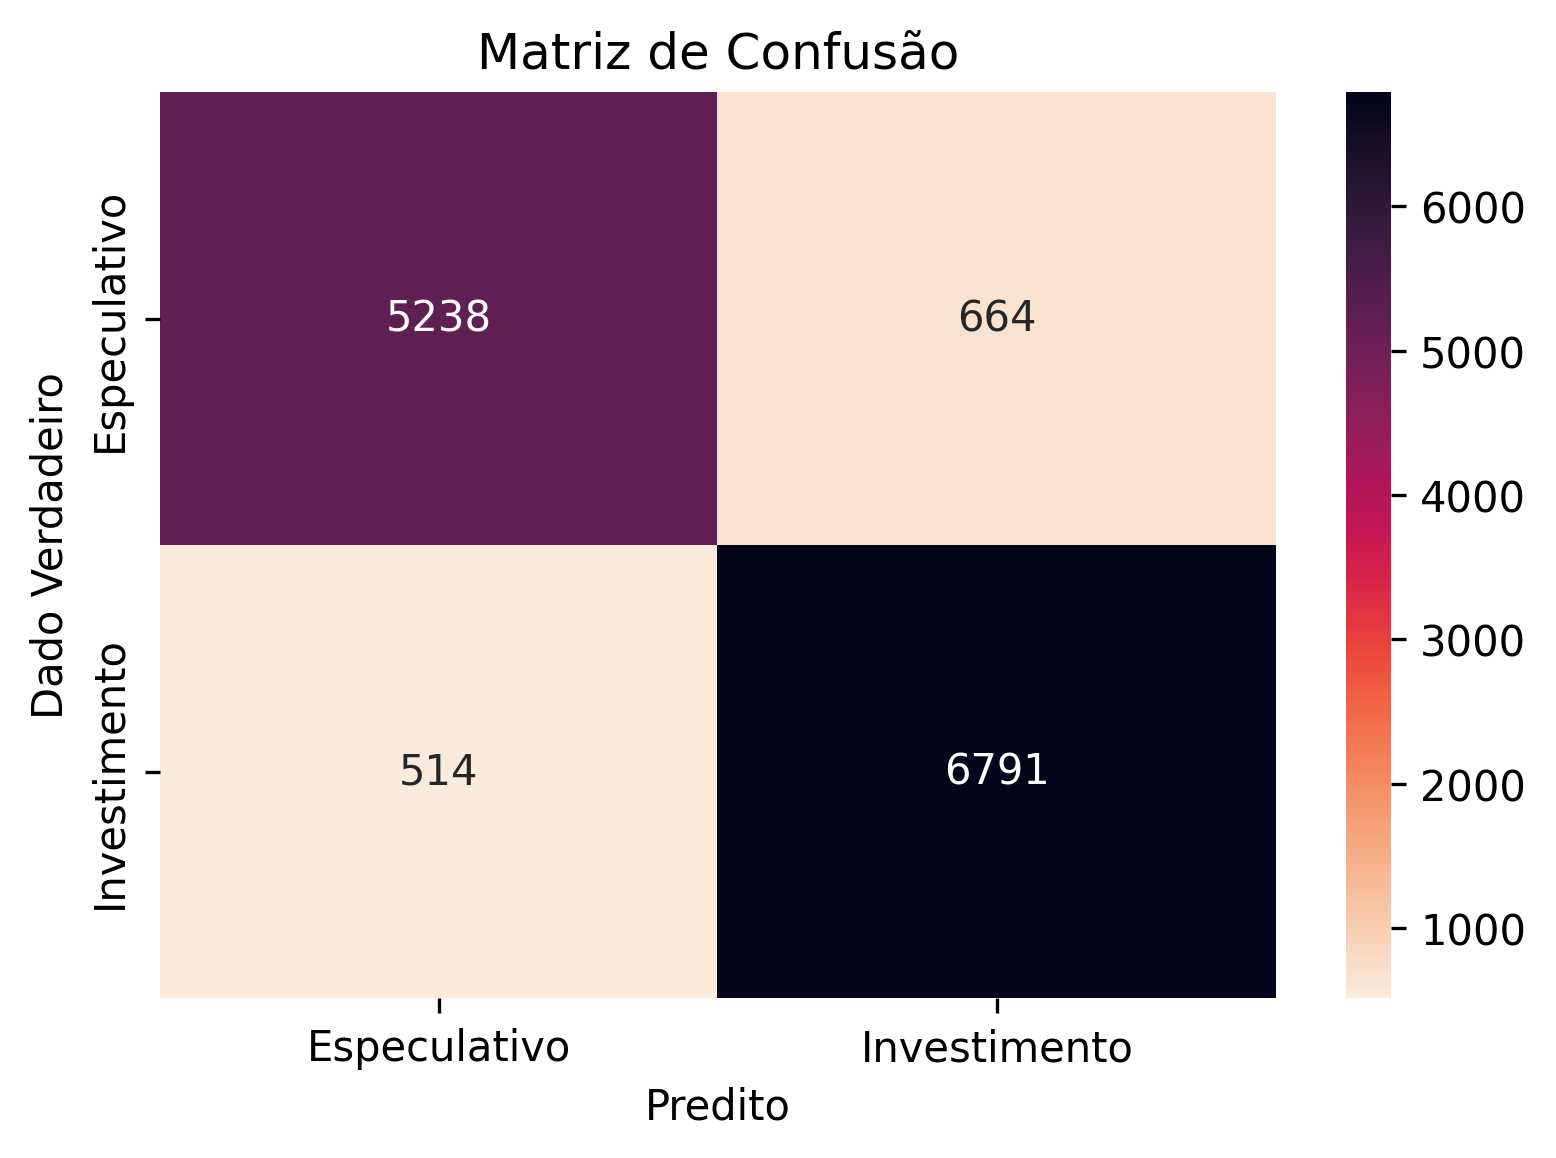

In [ ]:
from sklearn.metrics import confusion_matrix

top_clf = rating_bin.get_top_clfs()[-1]

cm = confusion_matrix(rating_bin.y_test, top_clf['clf'].predict(top_clf['X_test']))
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=sns.color_palette("rocket_r", as_cmap=True)); 

# labels, title and ticks
ax.set_xlabel('Predito');ax.set_ylabel('Dado Verdadeiro'); 
ax.set_title('Matriz de Confusão'); 
ax.xaxis.set_ticklabels(['Especulativo', 'Investimento']); ax.yaxis.set_ticklabels(['Especulativo', 'Investimento']);

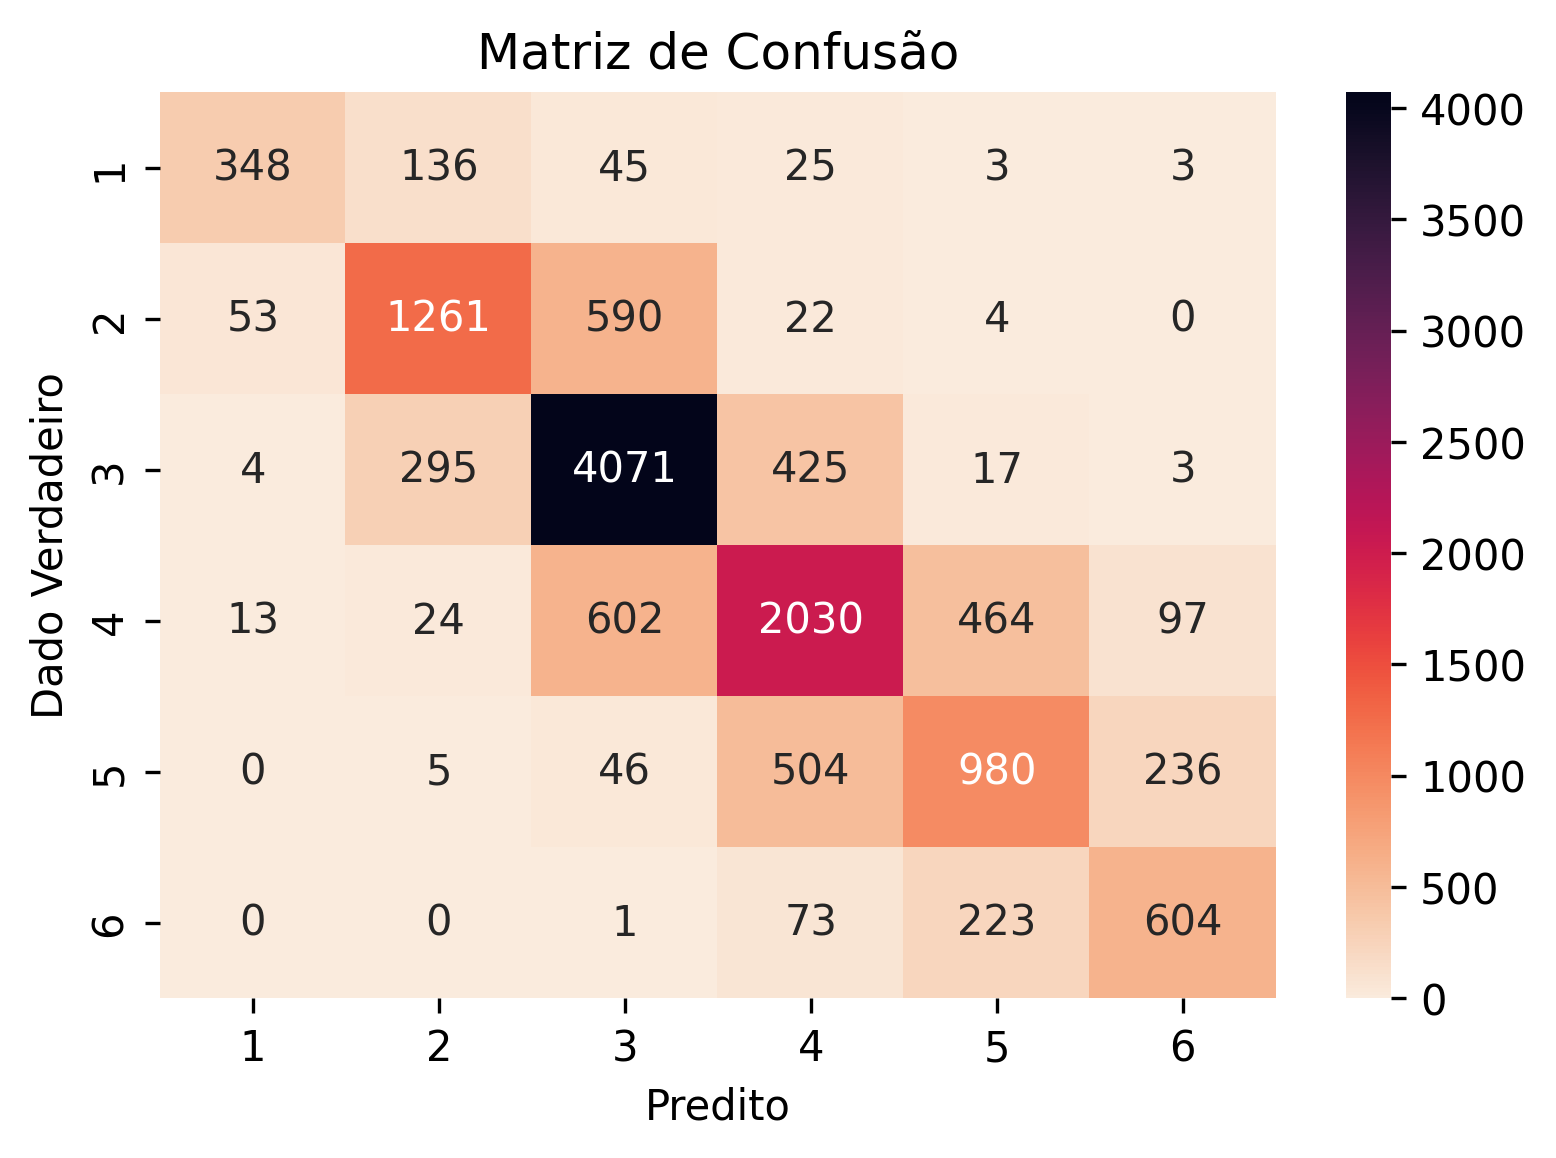

In [ ]:
from sklearn.metrics import confusion_matrix

top_clf = rating_mul.get_top_clfs()[-1]

cm = confusion_matrix(rating_mul.y_test, top_clf['clf'].predict(top_clf['X_test']))
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=sns.color_palette("rocket_r", as_cmap=True)); 

# labels, title and ticks
ax.set_xlabel('Predito');ax.set_ylabel('Dado Verdadeiro'); 
ax.set_title('Matriz de Confusão'); 
ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5', '6']); ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5', '6']);

In [ ]:
_SEP = ';'

def print_all_metrics_csv(modelagem, metrica_para_ordenar):
  header = ['nome', 'abordagem', 'test_f1', 'test_acc', 'test_recall', 'train_f1', 'train_acc', 'train_recall']
  results = []

  for model in modelagem.history.values():
    dic = {}

    dic['nome'] = modelagem.name
    dic['abordagem'] = '-'.join(model['name'])

    dic['test_f1'] = round(model['score']['test_f1'], 3)
    dic['test_acc'] = round(model['score']['test_acc'], 3)
    dic['test_recall'] = round(model['score']['test_recall'], 3)
    dic['train_f1'] = round(model['score']['train_f1'], 3)
    dic['train_acc'] = round(model['score']['train_acc'], 3)
    dic['train_recall'] = round(model['score']['train_recall'], 3)
    
    results.append(dic)

  print(_SEP.join(header)) # Header do CSV.

  results.sort(key=lambda x: x[metrica_para_ordenar])

  for dic in results:
    print(_SEP.join(str(dic[k]).replace('.', ',') for k in header))

print_all_metrics_csv(rating_bin, 'test_f1')

nome;abordagem;test_f1;test_acc;test_recall;train_f1;train_acc;train_recall
fin_rating_bin;Árvore de decisão-PCA;0,784;0,761;0,784;0,784;0,763;0,785
fin_rating_bin;Floresta Randômica-PCA;0,803;0,779;0,816;0,804;0,78;0,818
fin_rating_bin;Árvore de decisão-Originais;0,815;0,784;0,862;0,821;0,792;0,869
fin_rating_bin;Árvore de decisão-Normalização Std;0,854;0,841;0,84;0,865;0,854;0,85
fin_rating_bin;Floresta Randômica-Normalização Rob;0,854;0,835;0,874;0,861;0,843;0,882
fin_rating_bin;Floresta Randômica-Originais;0,858;0,84;0,878;0,864;0,847;0,884
fin_rating_bin;Floresta Randômica-Normalização Std;0,869;0,852;0,884;0,877;0,862;0,893
fin_rating_bin;Árvore de decisão-Normalização Rob;0,898;0,887;0,898;0,944;0,938;0,938
fin_rating_bin;Gradient Boosting-PCA;0,91;0,9;0,916;0,941;0,935;0,945
fin_rating_bin;Gradient Boosting-Normalização Std;0,917;0,908;0,926;0,95;0,944;0,955
fin_rating_bin;Gradient Boosting-Originais;0,92;0,911;0,93;0,947;0,941;0,953
fin_rating_bin;Gradient Boosting-Normalizaçã

In [ ]:
print_all_metrics_csv(rating_mul, 'test_f1')

nome;abordagem;test_f1;test_acc;test_recall;train_f1;train_acc;train_recall
fin_rating_multiple;Árvore de decisão-Normalização Rob;0,448;0,484;0,484;0,455;0,49;0,49
fin_rating_multiple;Árvore de decisão-Originais;0,461;0,481;0,481;0,468;0,488;0,488
fin_rating_multiple;Árvore de decisão-Normalização Std;0,493;0,508;0,508;0,511;0,525;0,525
fin_rating_multiple;Floresta Randômica-Normalização Rob;0,53;0,553;0,553;0,54;0,564;0,564
fin_rating_multiple;Floresta Randômica-Normalização Std;0,582;0,598;0,598;0,603;0,618;0,618
fin_rating_multiple;Floresta Randômica-Originais;0,588;0,603;0,603;0,617;0,632;0,632
fin_rating_multiple;Gradient Boosting-Normalização Std;0,7;0,703;0,703;0,789;0,79;0,79
fin_rating_multiple;Gradient Boosting-Originais;0,701;0,703;0,703;0,787;0,788;0,788
fin_rating_multiple;Gradient Boosting-Normalização Rob;0,701;0,704;0,704;0,783;0,785;0,785


In [ ]:
for x in rating_mul.get_imp_feats()[-10:]:
  print(f'{str(round(x[0]*100, 2)).replace(".", ",")}%; {mapper[x[1]]}')

2,7%; Soma do Passivo e Patrimônio Líquido
2,77%; Núm. de Ações
2,83%; Patrimônio permanente
3,93%; Aumento/Redução Patrimônio Líquido
4,22%; Ativos
4,54%; Lucro/Prejuízo por Ação Diluída
4,71%; Lucro/Prejuízo por Ação
5,0%; Patrimônio Líquido
7,21%; Despesa/Beneficio do IR
9,31%; Aumento/Redução do Lucro


In [ ]:
for x in rating_bin.get_imp_feats()[-10:]:
  print(f'{str(round(x[0]*100, 2)).replace(".", ",")}%; {x[1]}')

2,66%; Patrimônio permanente
2,84%; Núm. de Ações
2,87%; Valor declarado de ação comum
3,2%; Patrimônio Líquido
3,22%; Valor da ação comum
5,97%; Aumento/Redução Patrimônio Líquido
6,23%; Soma do Passivo e Patrimônio Líquido
6,62%; Despesa/Beneficio do IR
9,28%; Lucro/Prejuízo por Ação Diluída
15,69%; Aumento/Redução do Lucro


In [ ]:
from sklearn.metrics import confusion_matrix

top_clf = rating.get_top_clfs()[-1]

cm = confusion_matrix(rating.y_test, top_clf['clf'].predict(top_clf['X_test']))
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=sns.color_palette("rocket_r", as_cmap=True)); 

# labels, title and ticks
ax.set_xlabel('Predito');ax.set_ylabel('Dado Verdadeiro'); 
ax.set_title('Matriz de Confusão'); 
ax.xaxis.set_ticklabels(['Especulativo', 'Investimento']); ax.yaxis.set_ticklabels(['Especulativo', 'Investimento']);

In [ ]:
rating.print_importance_list()

Aumento/Redução de caixa: 0.40%
Ganho/Perda com financiamento: 0.55%
Investimentos em propriedades: 0.64%
Ganho/Lucro: 0.72%
Perda de lucro por operação: 0.72%
Ganhos com investimentos: 0.76%
Depreciação/Amortização: 0.84%
Perda de renda líquida: 0.87%
Crédito a curto prazo: 0.94%
Aumento/Redução de impostos: 0.99%
Ativos a longo prazo: 1.10%
Ganho/Perda com operações: 1.22%
Lucro/Prejuízo por Ação: 1.23%
Soma do Passivo e Patrimônio Líquido: 1.25%
Remuneração em Ações: 1.26%
Caixa ou Equivalentes: 1.27%
Núm. Máx de ações de sócios: 1.30%
Gastos com Juros: 1.37%
Valor declarado de sócios: 1.37%
Custos com transações: 1.42%
Ativos correntes: 1.62%
Passivo: 1.62%
Patrimônio de marca: 1.65%
Passivo Circulante: 1.67%
Despesa/Beneficio do IR: 2.06%
Patrimônio permanente: 2.12%
Propriedade e Equipamentos: 2.31%
Núm. de Ações criadas: 2.32%
Patrimônio Líquido: 2.40%
Valor declarado de ação comum: 2.64%
Valor da ação comum: 3.11%
Passivos a longo prazo: 3.14%
Núm. de Ações: 3.72%
Lucro/Prejuíz

In [ ]:
for x in X.columns:
  print(f'\item {x};')

\item Caixa ou Equivalentes;
\item Despesa/Beneficio do IR;
\item Ativos;
\item Soma do Passivo e Patrimônio Líquido;
\item Custos com transações;
\item Aumento/Redução de caixa;
\item Perda de renda líquida;
\item Patrimônio Líquido;
\item Aumento/Redução Patrimônio Líquido;
\item Aumento/Redução do Lucro;
\item Núm. de Ações criadas;
\item Núm. de Ações;
\item Lucro/Prejuízo por Ação;
\item Lucro/Prejuízo por Ação Diluída;
\item Propriedade e Equipamentos;
\item Gastos com Juros;
\item Ganhos com investimentos;
\item Perda de lucro por operação;
\item Valor da ação comum;
\item Ganho/Perda com financiamento;
\item Ganho/Perda com operações;
\item Patrimônio de marca;
\item Remuneração em Ações;
\item Núm. Máx de ações de sócios;
\item Valor declarado de ação comum;
\item Valor declarado de sócios;
\item Ativos correntes;
\item Passivo Circulante;
\item Aumento/Redução de impostos;
\item Investimentos em propriedades;
\item Passivo;
\item Patrimônio permanente;
\item Ativos a longo pr

In [ ]:

_SEP = ';'

def print_all_metrics_csv(modelagem, metrica_para_ordenar):
  header = ['nome', 'abordagem', 'test_f1', 'test_acc', 'test_recall', 'train_f1', 'train_acc', 'train_recall']
  results = []

  for model in modelagem.history.values():
    dic = {}

    dic['nome'] = modelagem.name
    dic['abordagem'] = '-'.join(model['name'])

    dic['test_f1'] = round(model['score']['test_f1'], 3)
    dic['test_acc'] = round(model['score']['test_acc'], 3)
    dic['test_recall'] = round(model['score']['test_recall'], 3)
    dic['train_f1'] = round(model['score']['train_f1'], 3)
    dic['train_acc'] = round(model['score']['train_acc'], 3)
    dic['train_recall'] = round(model['score']['train_recall'], 3)
    
    results.append(dic)

  print(_SEP.join(header)) # Header do CSV.

  results.sort(key=lambda x: x[metrica_para_ordenar])

  for dic in results:
    print(_SEP.join(str(dic[k]).replace('.', ',') for k in header))

print_all_metrics_csv(rating, 'test_f1')
  

nome;abordagem;test_f1;test_acc;test_recall;train_f1;train_acc;train_recall
fin_rating;Árvore de decisão-PCA;0,851;0,835;0,851;0,863;0,85;0,862
fin_rating;Árvore de decisão-Originais;0,887;0,875;0,885;0,919;0,912;0,914
fin_rating;Árvore de decisão-Normalização Std;0,89;0,878;0,897;0,914;0,905;0,92
fin_rating;Árvore de decisão-Normalização Rob;0,89;0,879;0,884;0,938;0,933;0,93


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

top_10 = [
'Núm. de Ações criadas',
'Patrimônio Líquido',
'Valor declarado de ação comum',
'Valor da ação comum',
'Passivos a longo prazo',
'Núm. de Ações',
'Lucro/Prejuízo por Ação Diluída',
'Aumento/Redução Patrimônio Líquido',
'Aumento/Redução do Lucro',
'Ativos']

kwa = {}

kwa['random_state'] = 43
kwa['test_size'] = 0.3

X_train, X_test, y_train, y_test = train_test_split(X[top_10]/100, y, **kwa)
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=400,max_leaf_nodes=15)

tree.fit(X_train, y_train)
test_clf(tree, X_train, X_test, y_train, y_test, binary=False)

{'test_acc': 0.7965472855304006,
 'test_f1': 0.7958855303572552,
 'test_recall': 0.7965472855304006,
 'train_acc': 0.8083663269942234}

In [ ]:
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import graphviz
 
plt.figure(figsize=(10,10))

kwa = {}

kwa['decision_tree'] = tree
kwa['out_file'] = None
kwa['feature_names'] = top_10
kwa['class_names'] = ['Investimento', 'Especulativo']
kwa['filled'] = True
kwa['label'] = 'root'
kwa['rounded'] = False
kwa['leaves_parallel'] = False
kwa['impurity'] = False
kwa['special_characters'] = True
kwa['proportion'] = False
kwa['precision'] = 2
kwa['rotate'] = False
kwa['fontname'] = 'times'

dot_data = export_graphviz(**kwa)

graph = graphviz.Source(dot_data)

graph.render(format='pdf', view=True)

'Source.gv.pdf'

<Figure size 720x720 with 0 Axes>

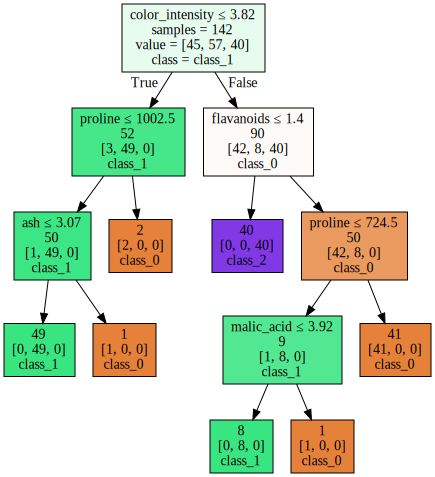

In [ ]:
graph

In [ ]:
rating = SolutionTester(clfs, X, y, 'fin_rating')

rating.run()

In [ ]:
dataset_clean['rating_step'].value_counts()

In [ ]:

from sklearn.model_selection import train_test_split

kwa = {}

kwa['random_state'] = 43
kwa['test_size'] = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, **kwa)
xgb = XGBClassifier()

xgb.fit(X_train, y_train)
test_clf(xgb, X_train, X_test, y_train, y_test)

{'test_acc': 0.6381166449781143,
 'test_f1': 0.6297705070506159,
 'train_acc': 0.6454494365405661}